In [1]:
import numpy as np
import scipy
import scipy.linalg
import matplotlib.pyplot as plt

# Base class from which our solver inherits
from numerical_eqs.pde.sdole import SDOLEPDESolver

from utils import *
from anelastic_solver import AnelasticSolver


def as_interwoven( M ):
    return M.T.reshape(-1)

def as_stacked( M, bandWidth ):
    return M.reshape(-1, bandWidth).T



def plot_sol( res, mesh, time_points, title='No title' ):
    
    sol_t = res['time']
    
    j = np.zeros(sol_t.shape)
    for t in time_points:
        j = np.logical_or(j, sol_t == t)
    # Find times that satisfy
    times = np.asarray(np.nonzero( j )).flatten()
    # 'times' now contains indeces of all time slices we'll want to plot
    
    fig, axs = plt.subplots(6, figsize=(8,20))
    for i, name in enumerate(('v0', 'v1', 'p0', 'p1', 'h')):
        for t in times:
            x = mesh
            y = res['ys'][t,i,:]
            
            if i > 1:
                x = x[:-1]
                y = y[:-1]
            axs[i].plot(
                x,
                y,
                label = 't={0}'.format(int(sol_t[t])),
            )
        axs[i].set_xlabel('meshpoints')
        axs[i].set_ylabel('value of {0}'.format(name))
        axs[i].set_title('{0}'.format(name))
        axs[i].legend()
        axs[i].grid()
    
    
    axs[-1].plot(
        sol_t[:-1],
        np.log(sol_t[1:] - sol_t[:-1]),
    )
    axs[-1].grid()
    axs[-1].set_title('{0}'.format('log(dt)'))
    
    fig.tight_layout()
    plt.show()

    
    

In [2]:
# 1 + N
meshsize = 1 + 200
mesh = np.linspace(0, 5, meshsize, endpoint=True)

def q(s):
    return np.where(
        s <= 0,
        0,
        np.where(
            s < 1,
            s**2 * (3-2*s),
            1
        )
    )
U0 = np.concatenate([
    
    # v0 component
    0 * mesh,
    
    # v1 component
    0 * mesh,
    
    # p0 component
    0 * mesh,
    
    # p1 component
    0 * mesh,
    
    # h component
    0.2 * q(4*mesh/5) + 0.4,
    
], axis=0).reshape(5,-1)


t0, t1 = (0, 10)

# Points in time that will be explicitly plotted below
time_points = list(range(0,12,2))


explicit_times = {
    'time points': time_points,
}


# These are useless in this iteration
boundaries = (
    {'type': 'neumann', 'f': lambda t: 0},
    {'type': 'neumann', 'f': lambda t: 0},
)


## Gravity Wave (small step)

100%|██████████| 10.0/10 [01:03<00:00,  6.40s/it]                


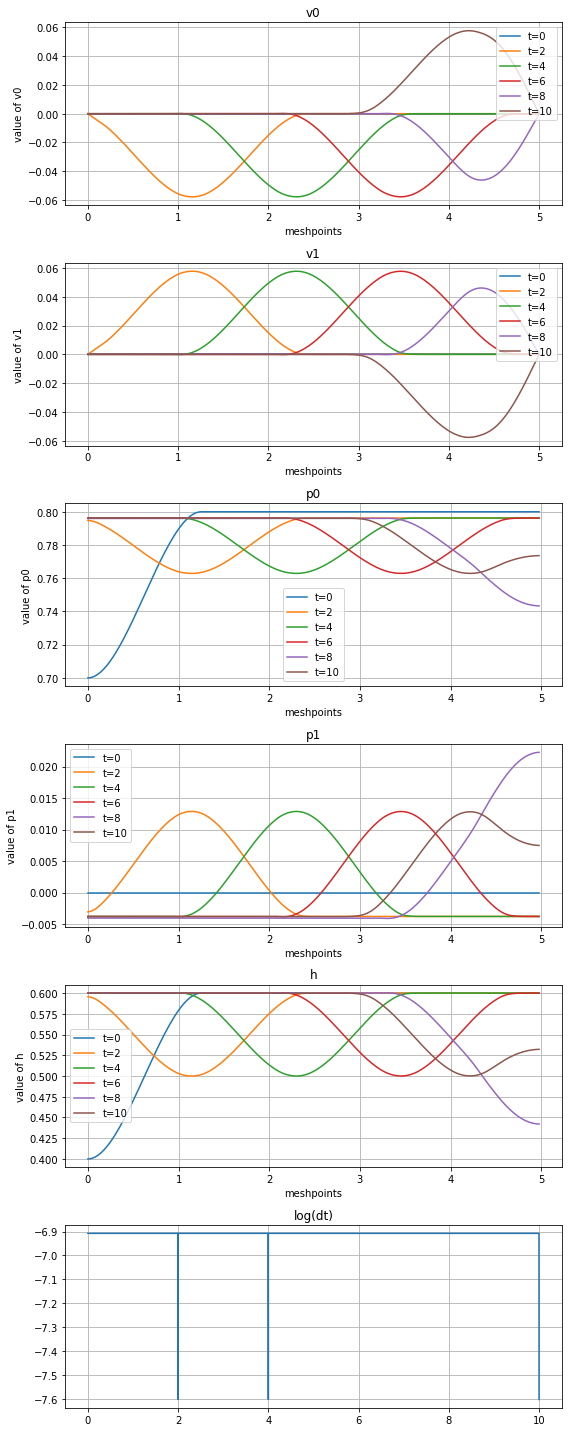

In [3]:


pde = AnelasticSolver(
    rho_0 = 1,
    rho_0_p = 1e-6,
    rho_1 = 1/2,
    rho_1_p = 0.5e-6,
    g = 1,
)
res = pde.solve(
    mesh = mesh,
    u0 = U0,
    t0 = t0,
    t1 = t1,
    # Add in boundaries
    boundaries = boundaries,
    
    explicit_times = explicit_times,
    # Show the progress bar
    progress = True,
    
    # Just disable step doubling
    time_controls = {
        'dtmin': 1e-3,
        'dtmax': 1e-3,
        'tol': 1e-3,
    }
)


plot_sol( res, mesh=mesh, time_points = time_points)

## Gravity Wave (adaptive step)

100%|██████████| 10.0/10 [00:03<00:00,  3.07it/s]                


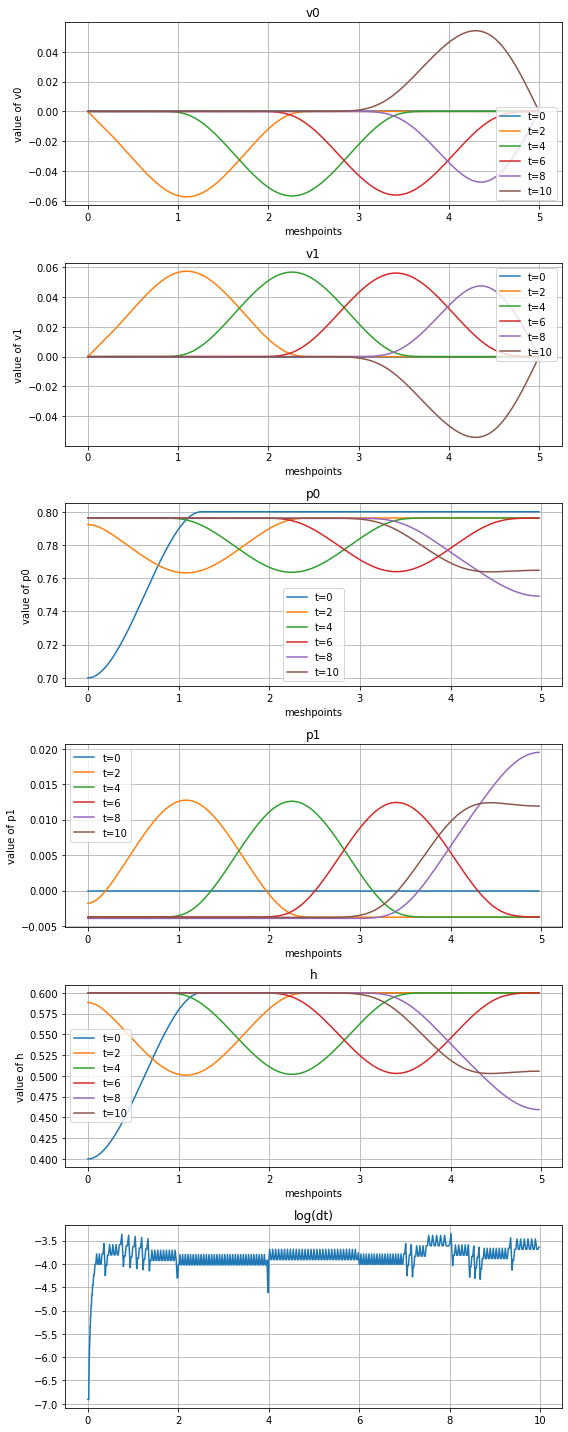

In [4]:
res = pde.solve(
    mesh = mesh,
    u0 = U0,
    t0 = t0,
    t1 = t1,
    # Add in boundaries
    boundaries = boundaries,
    
    explicit_times = explicit_times,
    # Show the progress bar
    progress = True,
    
    # Just disable step doubling
    time_controls = {
        'dtmin': 1e-3,
        'dtmax': 1,
        'tol': 1e-3,
    }
)


plot_sol( res, mesh=mesh, time_points = time_points)

## Pulse

100%|██████████| 0.004/0.004 [00:14<00:00, 3572.56s/it]                 


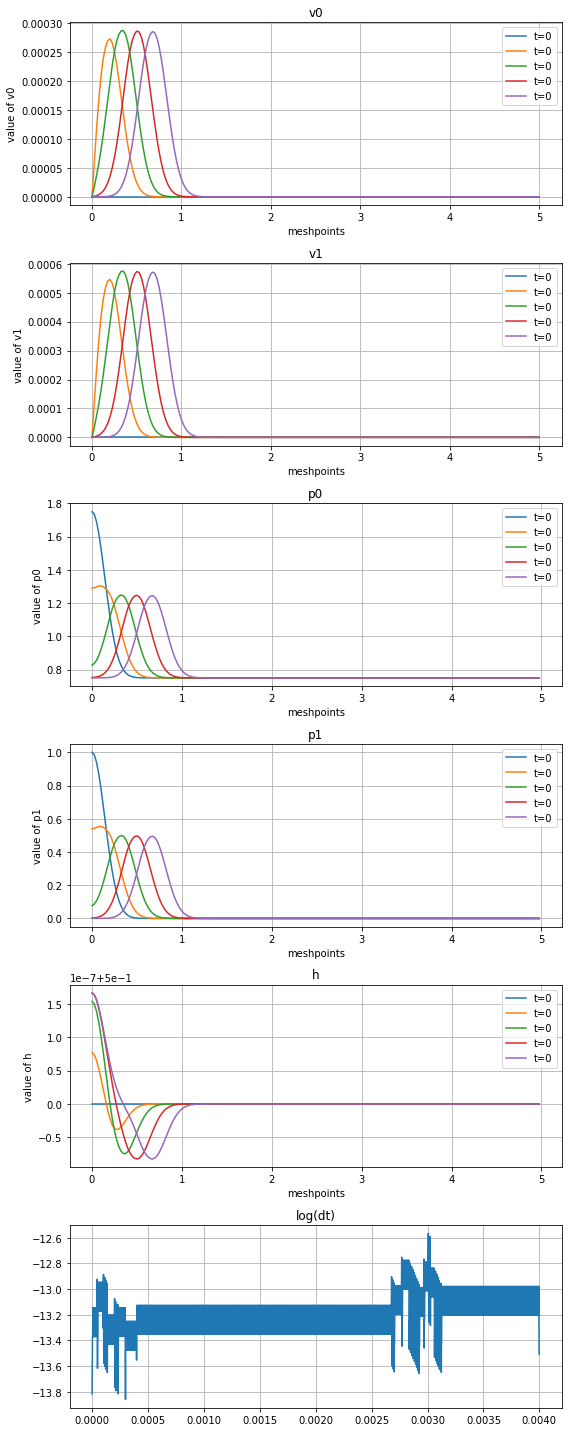

In [6]:
U0 = np.concatenate([
    
    # v0 component
    0 * mesh,
    
    # v1 component
    0 * mesh,
    
    # p0 component
    0 * mesh,
    
    # p1 component
    np.exp(-25*mesh**2),
    
    # h component
    0.5*np.ones(mesh.shape),
    
], axis=0).reshape(5,-1)

t0, t1 = (0, 4e-3)

# Points in time that will be explicitly plotted below
time_points = np.linspace(t0, t1, 5, endpoint=True).tolist()

explicit_times = {
    'time points': time_points,
}

res = pde.solve(
    mesh = mesh,
    u0 = U0,
    t0 = t0,
    t1 = t1,
    # Add in boundaries
    boundaries = boundaries,
    
    explicit_times = explicit_times,
    # Show the progress bar
    progress = True,
    
    # Just disable step doubling
    time_controls = {
        'dtmin': 1e-6,
        'dtmax': 1,
        'tol': 1e-3,
    }
)



plot_sol( res, mesh=mesh, time_points = time_points)